In [12]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import torch
import os
from torchvision.io import read_image
from pathlib import Path
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from torchvision.transforms import ToTensor
import pickle
from sklearn.model_selection import train_test_split

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
class CustomImageDataset(Dataset):
    def __init__(self, image_array, label_array, transform=None, target_transform=None):
        self.label_array = label_array
        self.image_array = image_array
        self.tranform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.image_array.shape[0]

    def __getitem__(self, idx):
        image = torch.Tensor(self.image_array[idx]).float()/255
        if self.tranform:
            image = self.tranform(image)
        label = float(self.label_array[idx])
        return image, label


In [15]:
# image_paths = []
# for folder in sorted(os.listdir("archive")):
#     file_path = os.path.join("archive", folder)
#     if ".DS_Store" not in folder:
#         for image in os.listdir(os.path.join(file_path, "0")):
#             image_path = os.path.join(file_path, "0", image)
#             image_paths.append(image_path)
#         for image in os.listdir(os.path.join(file_path, "1")):
#             image_path = os.path.join(file_path, "1", image)
#             image_paths.append(image_path) 

# image_paths = list(filter(lambda x: read_image(x).shape == (3, 50, 50), image_paths))
# image_obj = CustomImageDataset(image_paths)

with open("/kaggle/input/dataoriginalpkl/dataOriginal.pkl", "rb") as f:
    data = pickle.load(f)
    X_train, X_test, y_train, y_test = train_test_split(data["images"], data["labels"], test_size = 0.20, stratify=data["labels"])
    train_data = CustomImageDataset(X_train, y_train)
    test_data = CustomImageDataset(X_test, y_test)
    # stratification


In [16]:
data_loader_train = DataLoader(train_data, shuffle=True, batch_size=128)
data_loader_test = DataLoader(test_data, shuffle=True, batch_size=128)

# for image_batch, label_batch in data:
#     print(image_batch.shape)


In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, 5, stride=2),
            nn.MaxPool2d(2),
            # reduce max pool since there were too many parameters
            nn.BatchNorm2d(8),
            # added batch norm to improve it
            nn.ReLU(),
            nn.Conv2d(8, 16, 5, stride=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            # we added batch norm to improve it
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(1),
        )

    def forward(self, input):
        return self.network(input)

#net = NeuralNetwork().to(device)

In [18]:
epochs = 10
best_accuracy = -1
best_model = None
best_train = None
best_test = None
best_learning_rate = -1

for lr in [0.05, 0.1, 0.03, 0.25]:
    net = NeuralNetwork().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr)
    lossFn = torch.nn.BCEWithLogitsLoss()
    train_list = []
    val_list = []
    test_list = []
    # for parameter in net.parameters():
    #     print(parameter.numel())

    best_state_dict = None
    best_accuracy_temp = -1
    for epoch in tqdm(range(epochs)):
        losses = []
        net.train()
        for train_x, train_y in data_loader_train:
            train_x = train_x.to(device)
            train_y = torch.unsqueeze(train_y, 1).float().to(device)
            output = net(train_x)
            loss = lossFn(output, train_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss)
        print(f"Average loss {sum(losses)/len(losses)} for epoch {epoch}") 
        net.eval()
        with torch.no_grad():
            num_wrong = 0
            num_total = 0
            for test_x, test_y in data_loader_test:
                test_x = test_x.to(device)
                test_y = torch.unsqueeze(test_y, 1).float().to(device)
                output = torch.sigmoid(net(test_x)) > 0.5
                num_total += output.shape[0]
                num_wrong += torch.abs(output.long() - test_y).sum()
            test_list.append((1 - (num_wrong/num_total)).cpu())
            if best_accuracy_temp < test_list[-1]:
                best_accuracy_temp = test_list[-1]
                best_state_dict = net.state_dict()
            print(f"Test Accuracy:  {1 - (num_wrong/num_total)}") 
        with torch.no_grad(): 
            num_wrong_train = 0
            num_total_train = 0
            for test_x_train, test_y_train in data_loader_train:
                test_x_train = test_x_train.to(device)
                test_y_train = torch.unsqueeze(test_y_train, 1).float().to(device)
                output_train = torch.sigmoid(net(test_x_train)) > 0.5
                num_total_train += output_train.shape[0]
                num_wrong_train += torch.abs(output_train.long() - test_y_train).sum()
            train_list.append((1 - (num_wrong_train/num_total_train)).cpu())   
            print(f"Train Accuracy:  {1 - (num_wrong_train/num_total_train)}")
            
    if best_accuracy_temp > best_accuracy:
        net.load_state_dict(best_state_dict)
        best_model = net
        best_accuracy = best_accuracy_temp
        best_train = train_list
        best_test = test_list
        best_learning_rate = lr
            

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  0%|          | 0/10 [00:00<?, ?it/s]

Average loss 0.3727240264415741 for epoch 0
Test Accuracy:  0.8516668081283569


 10%|█         | 1/10 [00:31<04:41, 31.28s/it]

Train Accuracy:  0.8491259217262268
Average loss 0.3545323610305786 for epoch 1
Test Accuracy:  0.4624216556549072


 20%|██        | 2/10 [00:55<03:37, 27.17s/it]

Train Accuracy:  0.4636088013648987
Average loss 0.34139662981033325 for epoch 2
Test Accuracy:  0.5102370977401733


 30%|███       | 3/10 [01:19<03:01, 25.91s/it]

Train Accuracy:  0.5092856884002686
Average loss 0.3363243043422699 for epoch 3
Test Accuracy:  0.8391861319541931


 40%|████      | 4/10 [01:43<02:30, 25.10s/it]

Train Accuracy:  0.8373581171035767
Average loss 0.33457791805267334 for epoch 4
Test Accuracy:  0.6890726089477539


 50%|█████     | 5/10 [02:08<02:04, 24.83s/it]

Train Accuracy:  0.6874469518661499
Average loss 0.3315349817276001 for epoch 5
Test Accuracy:  0.8507403135299683


 60%|██████    | 6/10 [02:32<01:38, 24.74s/it]

Train Accuracy:  0.848676323890686
Average loss 0.33050116896629333 for epoch 6
Test Accuracy:  0.6277046203613281


 70%|███████   | 7/10 [02:57<01:13, 24.62s/it]

Train Accuracy:  0.6273180246353149
Average loss 0.3282434344291687 for epoch 7
Test Accuracy:  0.8378962278366089


 80%|████████  | 8/10 [03:21<00:49, 24.55s/it]

Train Accuracy:  0.8401604294776917
Average loss 0.3266964554786682 for epoch 8
Test Accuracy:  0.8656553626060486


 90%|█████████ | 9/10 [03:45<00:24, 24.41s/it]

Train Accuracy:  0.8652856349945068
Average loss 0.327095627784729 for epoch 9
Test Accuracy:  0.8135525584220886


100%|██████████| 10/10 [04:10<00:00, 25.02s/it]


Train Accuracy:  0.8132275342941284


  0%|          | 0/10 [00:00<?, ?it/s]

Average loss 0.3790496587753296 for epoch 0
Test Accuracy:  0.7137978076934814


 10%|█         | 1/10 [00:24<03:38, 24.25s/it]

Train Accuracy:  0.7138029932975769
Average loss 0.358972430229187 for epoch 1
Test Accuracy:  0.8533200025558472


 20%|██        | 2/10 [00:48<03:15, 24.38s/it]

Train Accuracy:  0.8515603542327881
Average loss 0.3578183948993683 for epoch 2
Test Accuracy:  0.8270142674446106


 30%|███       | 3/10 [01:13<02:50, 24.38s/it]

Train Accuracy:  0.8278021812438965
Average loss 0.35056960582733154 for epoch 3
Test Accuracy:  0.5199927091598511


 40%|████      | 4/10 [01:37<02:26, 24.42s/it]

Train Accuracy:  0.5186644792556763
Average loss 0.35060229897499084 for epoch 4
Test Accuracy:  0.8443636894226074


 50%|█████     | 5/10 [02:02<02:02, 24.46s/it]

Train Accuracy:  0.8444024324417114
Average loss 0.3454798758029938 for epoch 5
Test Accuracy:  0.7794531583786011


 60%|██████    | 6/10 [02:26<01:37, 24.45s/it]

Train Accuracy:  0.7787325382232666
Average loss 0.3444656431674957 for epoch 6
Test Accuracy:  0.846234917640686


 70%|███████   | 7/10 [02:50<01:13, 24.44s/it]

Train Accuracy:  0.843112587928772
Average loss 0.34308674931526184 for epoch 7
Test Accuracy:  0.8565173745155334


 80%|████████  | 8/10 [03:14<00:48, 24.30s/it]

Train Accuracy:  0.8535768985748291
Average loss 0.3426940441131592 for epoch 8
Test Accuracy:  0.8593696355819702


 90%|█████████ | 9/10 [03:39<00:24, 24.38s/it]

Train Accuracy:  0.8591451644897461
Average loss 0.3417123854160309 for epoch 9
Test Accuracy:  0.8134435415267944


100%|██████████| 10/10 [04:04<00:00, 24.41s/it]


Train Accuracy:  0.8121466040611267


  0%|          | 0/10 [00:00<?, ?it/s]

Average loss 0.3584297299385071 for epoch 0
Test Accuracy:  0.7786901593208313


 10%|█         | 1/10 [00:24<03:38, 24.33s/it]

Train Accuracy:  0.7776334285736084
Average loss 0.33261004090309143 for epoch 1
Test Accuracy:  0.8305568099021912


 20%|██        | 2/10 [00:48<03:13, 24.17s/it]

Train Accuracy:  0.8275932669639587
Average loss 0.32739928364753723 for epoch 2
Test Accuracy:  0.8229267001152039


 30%|███       | 3/10 [01:13<02:51, 24.48s/it]

Train Accuracy:  0.8218115568161011
Average loss 0.32424601912498474 for epoch 3
Test Accuracy:  0.8140794038772583


 40%|████      | 4/10 [01:37<02:27, 24.57s/it]

Train Accuracy:  0.8147990107536316
Average loss 0.32119691371917725 for epoch 4
Test Accuracy:  0.8471614122390747


 50%|█████     | 5/10 [02:02<02:02, 24.59s/it]

Train Accuracy:  0.8461828231811523
Average loss 0.3189600110054016 for epoch 5
Test Accuracy:  0.7777818441390991


 60%|██████    | 6/10 [02:26<01:37, 24.49s/it]

Train Accuracy:  0.7768340706825256
Average loss 0.3174765110015869 for epoch 6
Test Accuracy:  0.8576982617378235


 70%|███████   | 7/10 [02:50<01:12, 24.31s/it]

Train Accuracy:  0.8602760434150696
Average loss 0.3163687288761139 for epoch 7
Test Accuracy:  0.8145154118537903


 80%|████████  | 8/10 [03:14<00:48, 24.24s/it]

Train Accuracy:  0.8148534893989563
Average loss 0.31599026918411255 for epoch 8
Test Accuracy:  0.8713598251342773


 90%|█████████ | 9/10 [03:39<00:24, 24.27s/it]

Train Accuracy:  0.8709946870803833
Average loss 0.3141384720802307 for epoch 9
Test Accuracy:  0.864129364490509


100%|██████████| 10/10 [04:03<00:00, 24.37s/it]


Train Accuracy:  0.8646271228790283


  0%|          | 0/10 [00:00<?, ?it/s]

Average loss 0.6096228957176208 for epoch 0
Test Accuracy:  0.7137978076934814


 10%|█         | 1/10 [00:24<03:36, 24.11s/it]

Train Accuracy:  0.7138029932975769
Average loss 0.6005778908729553 for epoch 1
Test Accuracy:  0.7137978076934814


 20%|██        | 2/10 [00:48<03:13, 24.18s/it]

Train Accuracy:  0.7138029932975769
Average loss 0.6009295582771301 for epoch 2
Test Accuracy:  0.7137978076934814


 30%|███       | 3/10 [01:12<02:49, 24.27s/it]

Train Accuracy:  0.7138029932975769
Average loss 0.6011795997619629 for epoch 3
Test Accuracy:  0.7137978076934814


 40%|████      | 4/10 [01:37<02:25, 24.29s/it]

Train Accuracy:  0.7138029932975769
Average loss 0.6006240844726562 for epoch 4
Test Accuracy:  0.7137978076934814


 50%|█████     | 5/10 [02:00<02:00, 24.15s/it]

Train Accuracy:  0.7138029932975769
Average loss 0.6004818081855774 for epoch 5
Test Accuracy:  0.7137978076934814


 60%|██████    | 6/10 [02:25<01:36, 24.19s/it]

Train Accuracy:  0.7138029932975769
Average loss 0.6009544134140015 for epoch 6
Test Accuracy:  0.7137978076934814


 70%|███████   | 7/10 [02:49<01:12, 24.23s/it]

Train Accuracy:  0.7138029932975769
Average loss 0.6007916331291199 for epoch 7
Test Accuracy:  0.7137978076934814


 80%|████████  | 8/10 [03:13<00:48, 24.27s/it]

Train Accuracy:  0.7138029932975769
Average loss 0.6005446314811707 for epoch 8
Test Accuracy:  0.7137978076934814


 90%|█████████ | 9/10 [03:38<00:24, 24.32s/it]

Train Accuracy:  0.7138029932975769
Average loss 0.6005613803863525 for epoch 9
Test Accuracy:  0.7137978076934814


100%|██████████| 10/10 [04:02<00:00, 24.22s/it]

Train Accuracy:  0.7138029932975769


0.03
Best Test Accuracy:  tensor(0.8714)


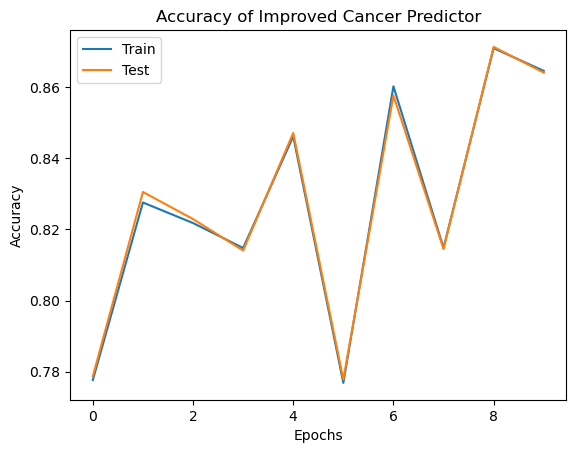

In [26]:
print(best_learning_rate)
print("Best Test Accuracy: ", max(best_test))

plt.plot(list(range(len(best_train))), best_train, label="Train")
plt.plot(list(range(len(best_test))), best_test, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of Improved Cancer Predictor")
plt.legend()
plt.show()

